# Final HW 2 - 김영인

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset # for loading dataset (mnist)
import torchvision.transforms as transforms # for processing datasets
from torch.utils.data import DataLoader # for making dataset easier to use 

from matplotlib import pyplot as plt
import numpy as np

device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device1 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"device: {device0}, {device1}") if torch.cuda.is_available() else print("device: cpu")

device: cuda:0, cuda:1


In [2]:
device = device1

# 2. CIFAR10

## Hyper parameter setting

In [21]:
lr = 1e-2
epochs = 100
batch_size = 128
act = nn.ReLU()
max_pool = nn.MaxPool2d(2,2)
display_step = 5
dropout_rate = .5
scheduler_step = 2
scheduler_gamma = 0.9

## Load data

Files already downloaded and verified
Files already downloaded and verified
len(train_data):  50000
len(test_data):  10000
data tensor([[[0.2314, 0.2431, 0.2471],
         [0.1686, 0.1804, 0.1765],
         [0.1961, 0.1882, 0.1686],
         ...,
         [0.6196, 0.5176, 0.4235],
         [0.5961, 0.4902, 0.4000],
         [0.5804, 0.4863, 0.4039]],

        [[0.0627, 0.0784, 0.0784],
         [0.0000, 0.0000, 0.0000],
         [0.0706, 0.0314, 0.0000],
         ...,
         [0.4824, 0.3451, 0.2157],
         [0.4667, 0.3255, 0.1961],
         [0.4784, 0.3412, 0.2235]],

        [[0.0980, 0.0941, 0.0824],
         [0.0627, 0.0275, 0.0000],
         [0.1922, 0.1059, 0.0314],
         ...,
         [0.4627, 0.3294, 0.1961],
         [0.4706, 0.3294, 0.1961],
         [0.4275, 0.2863, 0.1647]],

        ...,

        [[0.8157, 0.6667, 0.3765],
         [0.7882, 0.6000, 0.1333],
         [0.7765, 0.6314, 0.1020],
         ...,
         [0.6275, 0.5216, 0.2745],
         [0.2196, 0.1216, 

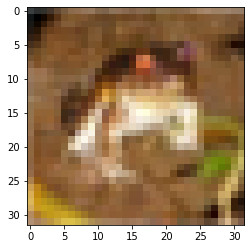

In [4]:
# load data
train_data = dataset.CIFAR10("./", train = True,
                             transform = transforms.ToTensor(),
                             target_transform = None,
                             download = True)
test_data = dataset.CIFAR10("./", train = False,
                            transform = transforms.ToTensor(),
                            target_transform = None,
                            download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
x_train = np.transpose(x_train, (1, 2, 0))

print('data', x_train)
print('data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train)
plt.show()

##  Pre-process data

data shape: torch.Size([128, 3, 32, 32])
label: tensor([1, 6, 9, 8, 6, 7, 6, 5, 1, 6, 0, 6, 1, 1, 3, 9, 0, 0, 0, 3, 2, 8, 2, 0,
        6, 4, 5, 8, 1, 1, 1, 9, 2, 3, 3, 7, 5, 3, 5, 9, 3, 7, 5, 3, 9, 3, 0, 6,
        8, 0, 9, 9, 5, 3, 9, 5, 6, 9, 3, 8, 7, 5, 3, 0, 1, 2, 0, 7, 2, 0, 9, 1,
        1, 1, 7, 9, 4, 4, 0, 1, 5, 2, 2, 7, 1, 8, 2, 2, 9, 0, 2, 8, 9, 2, 2, 3,
        9, 9, 3, 0, 8, 2, 0, 4, 2, 8, 8, 9, 7, 3, 8, 7, 5, 8, 3, 1, 3, 2, 1, 7,
        3, 9, 6, 2, 3, 7, 2, 8])


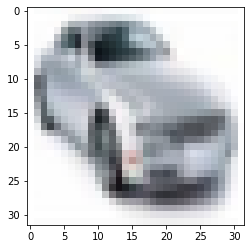

In [5]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers = 1,
                                           drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = 1,
                                          drop_last = True)

# check the data 
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('data shape:', example_data.shape)
print('label:', example_target)

check_image = example_data[0]
check_image = np.transpose(check_image, (1, 2, 0))

plt.figure()
plt.imshow(check_image)
plt.show()

In [6]:
def conv_2_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        max_pool
    )
    return model

def conv_3_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        max_pool
    )
    return model

def conv_4_block(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_dim),
        act,
        max_pool
    )
    return model

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            # original image : 3 * 32 * 32
            nn.Conv2d(3, 64, 3, padding=1),    # 64 * 32 * 32
            nn.BatchNorm2d(64),
            act,
            nn.Conv2d(64, 64, 3, padding=1),   # 64 * 32 * 32
            nn.BatchNorm2d(64),
            act,
            
            conv_2_block(64, 128),              # 128 * 16 * 16
            
            conv_3_block(128, 256),             # 256 * 8 * 8
            
            conv_3_block(256, 512),             # 512 * 4 * 4
            
            conv_3_block(512, 512),             # 512 * 2 * 2
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            act,
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            act,
            nn.Dropout(dropout_rate),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x)
        flatten = extracted_feature.view(x.shape[0], -1)
        logit = self.classifier(flatten)
        return logit

    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
model = CNN()
model.apply(init_weights)
model.to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size = scheduler_step,
                                      gamma = scheduler_gamma)

In [28]:
loss_array = []

# train the model
for i in range(epochs):
    scheduler.step()
    for index, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)        
        
        output = model.forward(data)
        loss = loss_function(output, label)
        
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print(f'{i} epoch loss: {loss}')
        loss_array.append(loss.cpu().detach().numpy())

0 epoch loss: 1.8385920524597168
5 epoch loss: 0.7284542322158813
10 epoch loss: 0.4587324261665344
15 epoch loss: 0.13921763002872467
20 epoch loss: 0.09726200252771378
25 epoch loss: 0.023902324959635735
30 epoch loss: 0.033932607620954514
35 epoch loss: 0.003229868598282337
40 epoch loss: 0.0033457267563790083
45 epoch loss: 0.003747837617993355
50 epoch loss: 1.4150848983263131e-05
55 epoch loss: 0.0031880498863756657
60 epoch loss: 1.4588005797122605e-05
65 epoch loss: 2.634134034451563e-05
70 epoch loss: 6.416475116566289e-06
75 epoch loss: 2.248422424599994e-05
80 epoch loss: 2.6439031444169814e-06
85 epoch loss: 1.0449282399349613e-06
90 epoch loss: 1.0821573823704966e-06
95 epoch loss: 8.661127708364802e-07


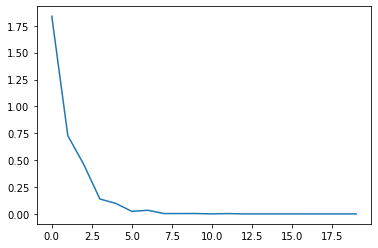

In [29]:
plt.figure()
plt.plot(loss_array)
plt.show()

In [30]:
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

Accuracy of the model: 0.8909254670143127


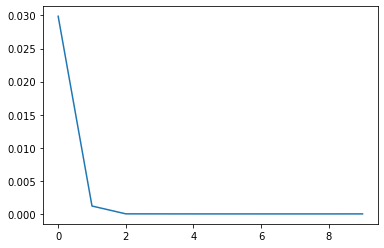

prediction : (128,)
true label : (128,)


array([[ 9,  0,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 0, 14,  0,  0,  0,  0,  0,  0,  1,  1],
       [ 1,  0,  9,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  3,  1,  1,  0,  0],
       [ 0,  0,  1,  1,  9,  0,  1,  1,  0,  0],
       [ 1,  0,  0,  0,  1, 16,  0,  0,  0,  0],
       [ 0,  0,  1,  2,  0,  1,  7,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  1,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  7,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  1,  0, 15]])

In [37]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred